In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime as dt

In [2]:
def aggregate_individual_data_per_day(raw=pd.DataFrame, to_average=None ):
    """
    for the raw data of one individual a new df is generated with the variables as columns. Values are summed unless their variable name is 
    specified to be averaged in to_average.

    Parameters
    ----------
    INPUT
    raw : df
        DataFrame with the raw data
    to_average : array-like
        array specifiying which variables to average

    RETURNS
    processed : df
        DataFrame wiht the processed data
    """
    raw = raw.copy()
    # add column with date only
    raw['time'] = pd.to_datetime(raw.loc[:,'time'])
    raw['time'] = raw['time'].dt.date

    # initialize new df with variables as columns
    vars = ['date', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather',
       'mood_std', 'circumplex.arousal_std', 'circumplex.valence_std',
       'activity_std']
    processed = pd.DataFrame(columns= vars)

    # fill df
    # loop over days
    for i, day in enumerate(raw['time'].unique()):
        processed.loc[i, 'time'] = day
        row = (raw['time'] == day)

        # loop over variables
        for col in vars[1:-1]:

            # average values of given specified variables
            if col in to_average:
                processed.loc[i, col] = raw.loc[row & (raw['variable'] == col)].value.mean()
                processed.loc[i, col+'_std'] = raw.loc[row & (raw['variable'] == col)].value.std()

            
            # sum values for the other variables
            else:
                processed.loc[i, col] = raw.loc[row & (raw['variable'] == col)].value.abs().sum()

    # sort the df according to date
    processed['time'] = pd.to_datetime(processed.loc[:,'time'])
    processed.sort_values('time')

    # drop rows without mood or or screen reading
    processed.drop(processed.loc[processed['mood'].isna() | (processed['screen'] == 0)].index, inplace=True)

    processed.reset_index(drop= True, inplace= True)
    
    processed.insert(1, 'weekday', processed['time'].dt.weekday)

    return processed

def aggregate_individual_data_per_reading(raw=pd.DataFrame, to_average=None ):
    """
    for the raw data of one individual a new df is generated with the variables as columns. Values are summed unless their variable name is 
    specified to be averaged in to_average.

    Parameters
    ----------
    INPUT
    raw : df
        DataFrame with the raw data
    to_average : array-like
        array specifiying which variables to average

    RETURNS
    processed : df
        DataFrame wiht the processed data
    """
    raw = raw.copy()
    # add column with date only
    raw['time'] = pd.to_datetime(raw.loc[:,'time'])
    raw.sort_values('time')

    # initialize new df with variables as columns
    vars = ['time', 'mood', 'circumplex.arousal', 'circumplex.valence',
       'activity', 'screen', 'call', 'sms', 'appCat.builtin',
       'appCat.communication', 'appCat.entertainment', 'appCat.finance',
       'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social',
       'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather', 'sleep']
    processed = pd.DataFrame(columns = vars)

    measure_times = raw['time'].loc[raw['variable'] == 'mood']
    # add an date in the past for first measurement
    measure_times = pd.concat([pd.to_datetime(pd.Series(['2014-01-01 00:00:00.000'])), measure_times], ignore_index=True)

    # fill df
    # loop over times
    for i in range(len(measure_times)-1):
        processed.loc[i, 'time'] = measure_times[i+1]
        rows = (measure_times[i] < raw['time']) & (raw['time'] <= measure_times[i+1])

        # loop over variables
        for col in vars[1:-2]:

            # average values of given specified variables
            if col in to_average:
                # using mean of 1 value to get single value and not an array
                processed.loc[i, col] = raw.loc[(raw['time'] == measure_times[i]) & (raw['variable'] == col)].value.mean()

            
            # sum values for the other variables
            else:
                processed.loc[i, col] = raw.loc[rows & (raw['variable'] == col)].value.abs().sum()

    hours = dt.time(12)
    processed['time'] = pd.to_datetime(processed.loc[:,'time'])

    # add column for sleep / rest time
    for i, day in enumerate(processed['time'].dt.date.unique()):

        day_before = day - dt.timedelta(1)

        processed['sleep'].loc[processed['time'].dt.date == day] \
            = raw['time'].loc[(raw['time'] > dt.datetime.combine(day_before, hours)) & (raw['time'] < dt.datetime.combine(day, hours))] \
            .diff().max().total_seconds() / 3600

    # sort the df according to date
    processed['time'] = pd.to_datetime(processed.loc[:,'time'])
    processed.sort_values('time')

    # delete all data points where mood or screen are 0
    processed.drop(processed.loc[processed['mood'].isna() | (processed['screen'] == 0)].index, inplace=True)
    #processed.drop(processed.loc[processed['mood'].isna()].index, inplace=True)

    processed.reset_index(drop= True, inplace= True)

    # check that screen time does not exceed the time intervalls
    for i in range(1,len(processed)):
        Dt = processed['time'].loc[i] - processed['time'].loc[i-1]
        Dt = Dt.seconds
        if  Dt < processed['screen'].loc[i]:
            processed.iloc[i, 5:-1] = np.nan

    processed.insert(1, 'weekday', processed['time'].dt.weekday)

    return processed

def aggregate_per_day_from_measurement(raw=pd.DataFrame, to_average=None ):
    """
    for the aggregated data per measurement the values are aggregated per day. Summed unless the column name is 
    specified to be averaged in to_average.

    Parameters
    ----------
    INPUT
    raw : df
        DataFrame with the aggragated data per measurement
    to_average : array-like
        array specifiying which variables to average

    RETURNS
    processed : df
        DataFrame wiht the processed data
    """
    raw = raw.copy()

    # add column with date only
    raw['time'] = pd.to_datetime(raw.loc[:,'time'])
    raw['time'] = raw['time'].dt.date

    # initialize new df with variables as columns
    vars = raw.columns
    processed = pd.DataFrame(columns= vars)

    # fill df
    # loop over days
    for i, day in enumerate(raw['time'].unique()):
        processed.loc[i, 'time'] = day
        processed.loc[i, 'weekday'] = day.weekday()
        processed.loc[i, 'sleep'] = raw['sleep'].loc[raw['time'] == day].unique()[0]
        row = (raw['time'] == day)

        # loop over variables
        for col in vars[2:-2]:

            # average values of given specified variables
            if col in to_average:
                processed.loc[i, col] = raw.loc[row, col].mean()
                #processed.loc[i, col+'_std'] = raw.loc[row, col].value.std()

            
            # sum values for the other variables
            else:
                processed.loc[i, col] = raw.loc[row, col].abs().sum()

    # sort the df according to date
    processed['time'] = pd.to_datetime(processed.loc[:,'time'])
    processed.sort_values('time')

    # # drop rows without mood or or screen reading
    # processed.drop(processed.loc[processed['mood'].isna() & (processed['screen'] == 0)].index, inplace=True)

    processed.reset_index(drop= True, inplace= True)

    return processed

In [3]:
raw_data = pd.read_csv('data/dataset_mood_smartphone.csv')

In [4]:
raw_data.drop('Unnamed: 0', inplace=True, axis=1)
raw_data.head()

,id,time,variable,value
0,AS14.01,2014-02-26 13:00:00.000,mood,6.0
1,AS14.01,2014-02-26 15:00:00.000,mood,6.0
2,AS14.01,2014-02-26 18:00:00.000,mood,6.0
3,AS14.01,2014-02-26 21:00:00.000,mood,7.0
4,AS14.01,2014-02-27 09:00:00.000,mood,6.0


In [7]:
for var in raw_data['variable'].unique():
    print(var)
    print(raw_data['value'].loc[raw_data['variable'] == var].describe())

mood
count    5641.000000
mean        6.992555
std         1.032769
min         1.000000
25%         7.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: value, dtype: float64
circumplex.arousal
count    5597.000000
mean       -0.098624
std         1.051868
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
circumplex.valence
count    5487.000000
mean        0.687808
std         0.671298
min        -2.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: value, dtype: float64
activity
count    22965.000000
mean         0.115958
std          0.186946
min          0.000000
25%          0.000000
50%          0.021739
75%          0.158333
max          1.000000
Name: value, dtype: float64
screen
count    96578.000000
mean        75.335206
std        253.822497
min          0.035000
25%          5.322250
50%         20.044500
75%         62.54

In [5]:
raw_data['time'] = pd.to_datetime(raw_data['time'])

In [6]:
# delete lonely values followed by long gap at the start of series
raw_data.drop(raw_data.loc[(raw_data.id == 'AS14.01') & (raw_data.time.dt.date == dt.date(2014, 2, 26))].index, inplace= True)
raw_data.drop(raw_data.loc[(raw_data.id == 'AS14.01') & (raw_data.time.dt.date == dt.date(2014, 2, 27))].index, inplace= True)
raw_data.drop(raw_data.loc[(raw_data.id == 'AS14.12') & (raw_data.time.dt.date == dt.date(2014, 3, 15))].index, inplace= True)
raw_data.dropna(inplace=True)

<Axes: >

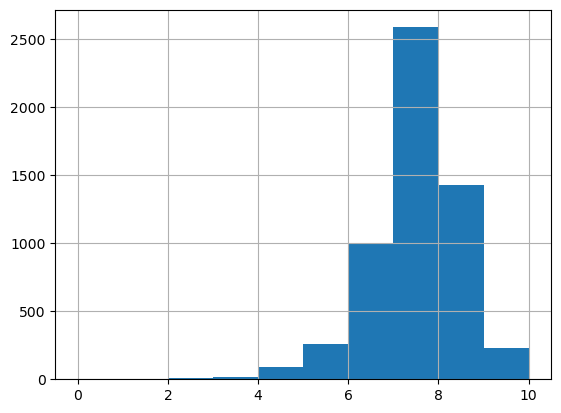

In [9]:
bins = np.arange(0,11,1)
raw_data['value'].loc[raw_data['variable'] == 'mood'].hist(bins=bins)

In [7]:
# cast id to integers
ids = raw_data['id'].unique()

### per day

In [8]:
# # specify variables to average
# to_average = np.array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity'])

# # process df for each individual
# processed_dfs = []
# for i in tqdm(ids):
#     raw_df = raw_data.loc[raw_data['id'] == i].copy()
#     processed_df = aggregate_individual_data_per_day(raw_df, to_average)
#     processed_dfs.append(processed_df)
#     processed_df.to_csv('aggregated_individual_data/'+str(i)+'_aggregated_per_day.csv')

### per measurement

In [9]:
# # specify variables to average
# to_average = np.array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity'])

# # process df for each individual
# processed_dfs_measure = []
# for i in tqdm(ids):
#     raw_df = raw_data.loc[raw_data['id'] == i].copy()
#     processed_df = aggregate_individual_data_per_reading(raw_df, to_average)
#     processed_dfs_measure.append(processed_df)
#     processed_df.to_csv('aggregated_individual_data_per_measurement/'+str(i)+'_aggregated_per_measurement.csv')

### per measurement and day

In [13]:
# specify variables to average
to_average = np.array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity'])
processed_dfs_measure = []
processed_dfs_day = []

for i in tqdm(ids):
    raw_df = raw_data.loc[raw_data['id'] == i].copy()
    processed_df = aggregate_individual_data_per_reading(raw_df, to_average)
    processed_dfs_measure.append(processed_df)
    processed_df.to_csv('data/aggregated_individual_data_per_measurement/'+str(i)+'_aggregated_per_measurement.csv')

    processed_df = aggregate_per_day_from_measurement(processed_df, to_average)
    processed_dfs_day.append(processed_df)
    processed_df.to_csv('data/aggregated_individual_data/'+str(i)+'_aggregated_per_day.csv')

  0%|          | 0/27 [00:00<?, ?it/s]/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_40891/1418575605.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed['sleep'].loc[processed['time'].dt.date == day] \
  4%|▎         | 1/27 [00:03<01:31,  3.51s/it]/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_40891/1418575605.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed['sleep'].loc[processed['time'].dt.date == day] \
  7%|▋         | 2/27 [00:05<01:04,  2.58s/it]/var/folders/98/yrk0x6wx2l9ckf4wfg4vr1z00000gn/T/ipykernel_40891/1418575605.py:126: SettingWithCopyWarning: 
A value i

In [11]:
processed_dfs_day[0]

,time,weekday,mood,circumplex.arousal,circumplex.valence,activity,screen,call,sms,appCat.builtin,...,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,sleep
0,2014-03-21,4,6.25,0.0,0.25,0.240971,15091.126,6.0,0.0,2706.775,...,18.196,0.0,62.281,228.715,4009.135,915.445,0.0,317.139,NaN,0 days 10:55:25.937000
1,2014-03-22,5,6.6,0.6,0.75,0.227151,6376.119999,3.0,1.0,913.582,...,52.424,0.0,109.925,97.125,439.632,37.305,0.0,117.621,NaN,0 days 19:13:02.746000
2,2014-03-23,6,6.6,0.2,0.4,0.114042,4258.870001,0.0,0.0,1138.127,...,0.0,0.0,0.0,52.658,367.596,0.0,0.0,0.0,NaN,0 days 14:22:12.741000
3,2014-03-24,0,5.8,1.0,0.0,0.197505,14915.900001,10.0,0.0,967.04,...,77.509,0.0,3.01,87.738,3691.595,419.805,0.0,208.818,NaN,0 days 14:13:42.800000
4,2014-03-25,1,7.0,0.75,0.75,0.108581,15055.802999,0.0,1.0,759.339,...,43.054,0.0,0.0,140.656,1527.405,0.0,235.223,74.431,NaN,0 days 16:27:04.166000
5,2014-03-26,2,6.4,-0.2,0.4,0.245389,19237.205,0.0,0.0,1136.575,...,20.175,0.0,0.0,133.651,3683.705,0.0,0.0,148.462,NaN,0 days 12:29:36.596000
6,2014-03-27,3,7.0,0.2,1.0,0.326086,23618.290999,2.0,1.0,1530.119,...,74.375,0.0,182.451,64.562,2301.075,47.314,0.0,197.306,NaN,0 days 14:04:18.645000
7,2014-03-28,4,6.4,-0.6,0.4,0.083298,4974.484,5.0,0.0,9977.109,...,89.166,233.036,0.0,222.926,512.741,1133.009,0.0,316.805,NaN,0 days 15:55:52.348000
8,2014-03-29,5,8.0,-0.2,1.0,0.148375,5732.092999,4.0,1.0,537.241,...,0.0,0.0,0.0,166.604,472.888,52.435,0.0,470.017,NaN,0 days 13:18:51.931000
9,2014-03-30,6,7.5,0.0,0.75,0.102381,6203.853001,0.0,0.0,1899.208,...,0.0,0.0,0.0,79.835,157.465,0.0,66.477,168.916,NaN,0 days 18:06:28.410000
